In [2]:
import pymongo
from pymongo import MongoClient
import pandas as pd
import numpy as np
import re
import json
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
#from emoji_unicode import UNICODE_EMO
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.text import Text
import string, re
from textblob_nl.nl import sentiment as pattern_sentiment
from textblob.classifiers import NaiveBayesClassifier
pd.set_option('max_colwidth', 1000)
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
client = MongoClient('localhost', 27017)
mydb = client.tweet
convos = mydb['convos']
tweets = mydb['_tweets']

In [4]:
air_names = ['@KLM', '@AirFrance', '@British_Airways', '@AmericanAir', '@Lufthansa', '@easyJet', '@RyanAir', '@SingaporeAir', '@Qantas', '@EtihadAirways', '@VirginAtlantic']

In [5]:
airlines = {'KLM':56377143, 
            'AirFrance': 106062176, 
            'British_Airways': 18332190, 
            'AmericanAir': 22536055, 
           'Lufthansa': 124476322, 
           'AirBerlin': 26223583, 
           'AirBerlinAssist': 2182373406, 
           'easyJet': 38676903, 
           'RyanAir': 1542862735, 
           'SingaporeAir': 253340062, 
           'Qantas': 218730857, 
           'EtihadAirways': 45621423, 
           'VirginAtlantic': 20626359}

* Created a dataframe which includes tweets in english to the airlines, along with the tweet id, user id and timestamp.

In [6]:
jdf = pd.DataFrame()
jdf['tweet'] = [t['text'] for t in tweets.find({}) for n in air_names if n in t['text'] if t['language']=='eng']
jdf['id'] = [t['id'] for t in tweets.find({}) for n in air_names if n in t['text'] if t['language']=='eng']
jdf['user_id'] = [t['user']['id'] for t in tweets.find({}) for n in air_names if n in t['text'] if t['language']=='eng']
jdf['timestamp'] = [t['timestamp_ms'] for t in tweets.find({}) for n in air_names if n in t['text'] if t['language']=='eng']

* Added a new column which states which airline the tweet is referring to.

In [7]:
temp=jdf.tweet.fillna("0")
jdf['airline'] = pd.np.where(temp.str.contains("@KLM"),"KLM",
           pd.np.where(temp.str.contains("@British_Airways"), "British_Airways",
           pd.np.where(temp.str.contains("@easyJet"), "easyJet",
           pd.np.where(temp.str.contains("@AmericanAir"), "AmericanAir",
           pd.np.where(temp.str.contains("@Lufthansa"), "Lufthansa",
           pd.np.where(temp.str.contains("@RyanAir"), "RyanAir",
           pd.np.where(temp.str.contains("@AirBerlin"), "AirBerlin",
           pd.np.where(temp.str.contains("@AirBerlinAssist"), "AirBerlinAssist",
           pd.np.where(temp.str.contains("@AirFrance"), "AirFrance",
           pd.np.where(temp.str.contains("@SingaporeAir"),"SingaporeAir",
           pd.np.where(temp.str.contains("@Qantas"), "Qantas",
           pd.np.where(temp.str.contains("@EtihadAirways"), "EtihadAirways",
           pd.np.where(temp.str.contains("@VirginAtlantic"), "VirginAtlantic", "na")))))))))))))

C:\Users\jonal\Anacondaa\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  
C:\Users\jonal\Anacondaa\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\jonal\Anacondaa\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  after removing the cwd from sys.path.
C:\Users\jonal\Anacondaa\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  """
C:\Users\jonal\Anacondaa\lib\site-packages\ipykernel_launcher.py:

In [8]:
jdf.head()

,tweet,id,user_id,timestamp,airline
0,@easyJet It is impossible to get in contact with you by using that e-mail address. So there is no claim yet which I can follow on that damage luggage website. So what to do?,1131173038194606100,19610469,1558527643141,easyJet
1,Do you remember when you joined Twitter? I do! #MyTwitterAnniversary Meh. Sure let’s fly Full throttle into this Jovian Sh*tstorm. @NasaJuno #JunoMission @KLM #Wintje https://t.co/2PaxhMimlu,1131173692086599700,728236673037914100,1558527799041,KLM
2,"@AmericanAir flight delays this morning due to mechanical problems. A hassle, but glad to be on the ground while they fix the problems. #beingproductive",1131174000695160800,204548115,1558527872619,AmericanAir
3,"@AmericanAir started out being charged for my luggage when I used my AAdvantage card so it should have been free. Now in Philly, only to find the plane needs a 4 hour repair. Mysteriously now they say 2 hours. Closing my account and won't be flying AA again",1131174316014489600,39829618,1558527947797,AmericanAir
4,"So @AmericanAir @EWRairport lied to an old lady causing her to miss her flight #934 to LHR. She arrived at 6:05am for a flight departing at 8:30am,mum has no medication,is in a wheelchair and they just ignore the fact they caused this.Worse airline company. Zero customer service",1131173065122078700,2730172562,1558527649561,AmericanAir


* Created a function which cleans the text by removing links, hashtags, @mentions and other redundant things to make the sentiment analysis easier. And then applied it do the tweets in the dataframe.

In [27]:
def cleantxt(text):
    text = text.lower()
    text = re.sub('airline', '', text)
    text = re.sub('please', '', text)
    text = re.sub('travel', '', text)
    text = re.sub('airways', '', text)
    text = re.sub('amp', '', text)
    text = re.sub('amsterdam', '', text)
    text = re.sub('singapore', '', text)
    text = re.sub('people', '', text)
    text = re.sub('flight', '', text)
    text = re.sub('\[.*?\]', '', text) 
    text = re.sub(r'@[A-Za-z0-9]+', '', text) 
    text = re.sub(r'https?:\/\/\S+', '', text) 
    text = re.sub(r'RT[\s]+', '', text) 
    text = re.sub(r'#[A-Za-z0-9]+', '', text)  
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('\n', '', text)
    #for emot in UNICODE_EMO:
    #    text = re.sub(r'('+emot+')', "_".join(UNICODE_EMO[emot].replace(",","").replace(":","").split()), text)
    return text

In [10]:
jdf['tweet'] = jdf['tweet'].apply(cleantxt)
jdf[['tweet']]

,tweet
0,it is impossible to get in contact with you by using that email address so there is no claim yet which i can follow on that damage luggage website so what to do
1,do you remember when you joined twitter i do meh sure let’s fly full throttle into this jovian shtstorm
2,delays this morning due to mechanical problems a hassle but glad to be on the ground while they fix the problems
3,started out being charged for my luggage when i used my aadvantage card so it should have been free now in philly only to find the plane needs a hour repair mysteriously now they say hours closing my account and wont be flying aa again
4,so lied to an old lady causing her to miss her to lhr she arrived at for a departing at has no medicationis in a wheelchair and they just ignore the fact they caused thisworse company zero customer service
...,...
736814,trying to get a hold of a customer service person to talk through options for my upcoming due to but every time i call theres not even an option to hold or receive a call back it just hangs up help
736815,it’s a total nightmare i’ve just seen that ny has declared a state emergency so i’m hoping our bookings will be cancelled and refunded or we can change the dates 🤞🏼😩
736816,my mother is due to she is years old with a pacemaker i find it really very hard to believe ba would not give her a credit note given the global health warnings poor lady is equally depressed about losing money as getting ill have a heart ba
736817,absent fever and risk factors attendants as screeners come on mike your playing advocatus diaboli to a nonsensical extreme


* Getting most common words and removing them because not much value

In [11]:
from collections import Counter
cnt = Counter()
for text in jdf["tweet"].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(20)

[('to', 950036),
 ('the', 791394),
 ('and', 513489),
 ('a', 506324),
 ('i', 466897),
 ('you', 368348),
 ('for', 349753),
 ('on', 309170),
 ('in', 303023),
 ('of', 296865),
 ('is', 285683),
 ('my', 268935),
 ('have', 200113),
 ('with', 199548),
 ('it', 192244),
 ('this', 188206),
 ('that', 178468),
 ('your', 168172),
 ('not', 162926),
 ('are', 153902)]

In [12]:
FREQWORDS = set([w for (w, wc) in cnt.most_common(16)])
def remove_freqwords(text):
    """custom function to remove the frequent words"""
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

jdf['tweet'] = jdf['tweet'].apply(remove_freqwords)
jdf[['tweet']].head()

,tweet
0,impossible get contact by using that email address so there no claim yet which can follow that damage luggage website so what do
1,do remember when joined twitter do meh sure let’s fly full throttle into jovian shtstorm
2,delays morning due mechanical problems hassle but glad be ground while they fix problems
3,started out being charged luggage when used aadvantage card so should been free now philly only find plane needs hour repair mysteriously now they say hours closing account wont be flying aa again
4,so lied an old lady causing her miss her lhr she arrived at departing at has no medicationis wheelchair they just ignore fact they caused thisworse company zero customer service


* Training a classifier which then classifies each tweet into a positive one or negative.

In [32]:
train = [
    ('i wish the food service was better', 'neg'),
    ('Great costumer service!', 'pos'),
    ('I am happy with the flight and service', 'pos'),
    ('glad I chose this airline', 'pos'),
    ('fucking costumer service is so bad', 'neg'),
    ('The flight was late, I am not happy with this', 'neg'),
    ('I will never fly with this airline again', 'neg'),
    ('Airline sucks at organization, total nightmare', 'neg'),
    ('Staff was very helpful, very nice', 'pos'),
    ('great to see such developments!', 'pos'),
    ('Today was my last trip outside schengen with klm / amsterdam is the worst airport for international connecting flights', 'neg'),
    ('I like flying with this airline!', 'pos'),
    ('its not helping me at all. Companies too big to solve real problems', 'neg'),
    ('your staff seemingly unaware', 'neg'),
    ('Thank you. But thats not enough. If my flight is delayed more than 3 hours, you must advise Im entitled to assistance AND compensation. Not just say download the brochure.', 'neg'),
    ('worst experience in my life,', 'neg'),
    ('last minute flight cancellation, very dissapointed', 'neg'),
    ('great job at cancelling our flight again!', 'neg'), #sarcasm
    ('you have truly excelled yourself in providing the worst customer service ever', 'neg'), #sarcasm
    ('the food on this airplane was delicious', 'pos'),
    ('delighted with the costumer service here', 'pos'),
    ('the money was refunded quite fast, thanks', 'pos'),
    ('i lost my bag/luggage, but the flight attendants helped me, thank you', 'pos'),
    ('i was disappointed because noone helped me find my luggage/bag', 'neg'),
    ('the flight was very pleasant and fast', 'pos'),
    ('very slow check-in', 'neg'),
    ('the food was bad, maybe u should fix that', 'neg'),
    ('im trying reserve seat upcoming every time give technical error site invite contact resolve help please', 'neg'),
    ('very uncomfortable seats, my back hurts', 'neg'),
    ('the flight was delayed AGAIN, so typical of them', 'neg'),
    ('great work take a suit carrier off me and then have me waste a full hour waiting on your incompetent services', 'neg')
]

test = [
    ('I wish the food on the plane was better, disgusting', 'neg'),
    ('the check-in was very slow', 'neg'),
    ('i wish the check in was faster', 'neg'),
    ('delightful with the costumer service!', 'pos'),
    ('the flight was fast and steady', 'pos'),
    ('fucking costumer service sucks', 'neg'),
    ('it took so long to get my money refunded, maybe you can fix that', 'neg'),
    ('good job at cancelling the flight', 'neg'), #sarcasm
    ('no one from this agency helped me find my bag', 'neg'),
    ('flight attendant helped me with finding my bag, thank you', 'pos'),
    ('helpful staff, glad i chose this airline', 'pos'),
    ('im having technical issues in the site, help please', 'neg'),
    ('me and my family are happy with your service', 'pos'),
    ('the seats were very uncomfortable,', 'neg'),
    ('no space for my legs','neg'),
    ('2/10 experience, people were treated badly', 'neg'),
    ('your reply didnt help me at all', 'neg'),
    ('thank you for replying, that helped a lot', 'pos'),
    ('i hope you actually reply to me this time, i have a big problem', 'neg')
]

cl = NaiveBayesClassifier(train)
cl.accuracy(test)

0.8947368421052632

* Created a function based on the classifier, and applied it to the tweets.

In [33]:
def classify(text):
    prob_dist = cl.prob_classify(text)
    return prob_dist.max()

In [98]:
classify('happy with the great work they do providing services under very challenging conditions. big thanks to all of you')

'pos'

In [99]:
classify('how about a refund? you cancelled my flight, forced me to accept vouchers and now say that you will not refund for 12 months!')

'neg'

In [15]:
jdf['class'] = jdf['tweet'].apply(classify)

In [16]:
jdf.head()

,tweet,id,user_id,timestamp,airline,class
0,impossible get contact by using that email address so there no claim yet which can follow that damage luggage website so what do,1131173038194606100,19610469,1558527643141,easyJet,neg
1,do remember when joined twitter do meh sure let’s fly full throttle into jovian shtstorm,1131173692086599700,728236673037914100,1558527799041,KLM,neg
2,delays morning due mechanical problems hassle but glad be ground while they fix problems,1131174000695160800,204548115,1558527872619,AmericanAir,pos
3,started out being charged luggage when used aadvantage card so should been free now philly only find plane needs hour repair mysteriously now they say hours closing account wont be flying aa again,1131174316014489600,39829618,1558527947797,AmericanAir,neg
4,so lied an old lady causing her miss her lhr she arrived at departing at has no medicationis wheelchair they just ignore fact they caused thisworse company zero customer service,1131173065122078700,2730172562,1558527649561,AmericanAir,neg


In [17]:
jdf['class'].value_counts()

neg    616016
pos    120803
Name: class, dtype: int64

In [18]:
jdf['airline'].value_counts()

AmericanAir        259106
British_Airways    200517
easyJet            102991
KLM                 46782
Qantas              44506
VirginAtlantic      42709
SingaporeAir        18694
EtihadAirways       12667
Lufthansa            5230
AirFrance            3457
RyanAir               160
Name: airline, dtype: int64

* Visualization of most used words from the tweets split into negative and positive.

In [ ]:
negdf = jdf[jdf['class']=='neg']
negwords = ''.join([t for t in negdf['tweet']])
 
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=500,
                      height=300
                     ).generate(negwords)
plt.figure(1,figsize=(7, 7))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Most used words in the negative class')
plt.show()

In [ ]:
posdf = jdf[jdf['class']=='pos']
poswords = ''.join([t for t in posdf['tweet']])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=500,
                      height=300
                     ).generate(poswords)
plt.figure(1,figsize=(7, 7))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Most used words in the positive class')
plt.show()

* Negative words used when tweeting KLM

In [ ]:
knegdf = jdf[jdf['class']=='neg']
klmneg = knegdf[knegdf['airline']=='KLM']
klmnegwords = ''.join([t for t in klmneg['tweet'] ])
wlst = ['food', 'time', 'hour', 'wait', 'miss', 'suck','fuck','shit','seat','loud','fix','line','lost','lose','bag','talk','flew','call','fast','slow','pay'
       ,'long','care','shame','']

finalst = [w for w in klmnegwords.split() if len(w)>5 or w in wlst]
finafina = ' '.join([w for w in finalst])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=500,
                      height=300,
                      collocations=False
                     ).generate(finafina)
plt.figure(1,figsize=(15, 15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Negative words used for KLM',fontsize=15)
plt.show()

In [ ]:
for t in klmneg['tweet']:
    if 'breastfeeding' in t :
        print(t)

Top 15 most used words in the negative tweets sent to KLM 

In [ ]:
cnt = Counter()
for w in finalst:
    if w not in STOPWORDS:
        cnt[w] += 1
        
cnt.most_common(15)

* Negative words used for Singapore Air

In [ ]:
snegdf = jdf[jdf['class']=='neg']
sneg = snegdf[snegdf['airline']=='SingaporeAir']
snegwords = ''.join([t for t in sneg['tweet']])
wlst = ['food', 'time', 'hour', 'wait', 'miss', 'suck','fuck','shit','seat','loud', 'card','air','help','fix','card','line','need','lost','lose','bag','talk','flew','call','fast','slow','pay'
       ,'long','care','shame']

finalst = [w for w in snegwords.split() if len(w)>5 or w in wlst]
finafina = ' '.join([w for w in finalst])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=500,
                      height=300,
                      collocations=False
                     ).generate(finafina)

plt.figure(1,figsize=(15, 15))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Negative words used for Singapore Air',fontsize=15)
plt.show()

Top 15 most used words in the negative tweets sent to Singapore Air

In [ ]:
cnt = Counter()
for w in finalst:
    if w not in STOPWORDS:
        cnt[w] += 1
        
cnt.most_common(15)

In [ ]:
kposdf = jdf[jdf['class']=='pos']
klmpos = kposdf[kposdf['airline']=='KLM']
klmposwords = ''.join([t for t in klmpos['tweet']])
nowlst = ['will','make','new','day','see','need','still','im','india','even','wa','ha','via','got','take','uk','dont','want',
        'think','from','us','any','don']
pfinalst = [w for w in klmposwords.split() if len(w)>5 or if w not in nowlst]

pfinafina = ' '.join([w for w in pfinalst])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=500,
                      height=300
                     ).generate(pfinafina)
plt.figure(1,figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Positive words used for KLM')
plt.show()

* Some visualized comparisons between airlines.

Number received tweets per airline

Text(0, 0.5, 'No. of Tweets')

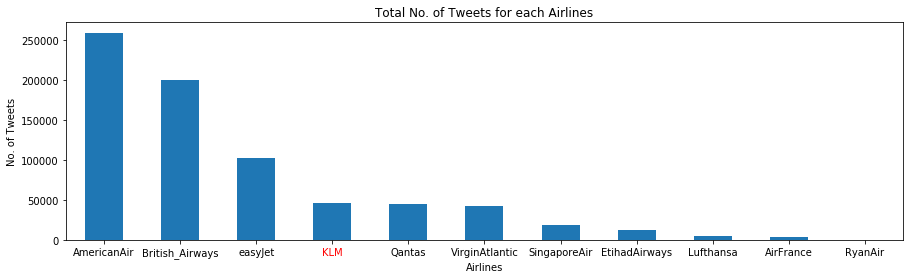

In [68]:
#colors=sns.dark_palette("purple") 
pd.Series(jdf["airline"]).value_counts().plot(kind = "bar",
                        figsize=(15,4),fontsize=10,rot = 0, title = "Total No. of Tweets for each Airlines").get_xticklabels()[3].set_color('red');
#a[3].set_color('r')
plt.xlabel('Airlines', fontsize=10)
plt.ylabel('No. of Tweets', fontsize=10)

Number of positive and negative tweets per airline

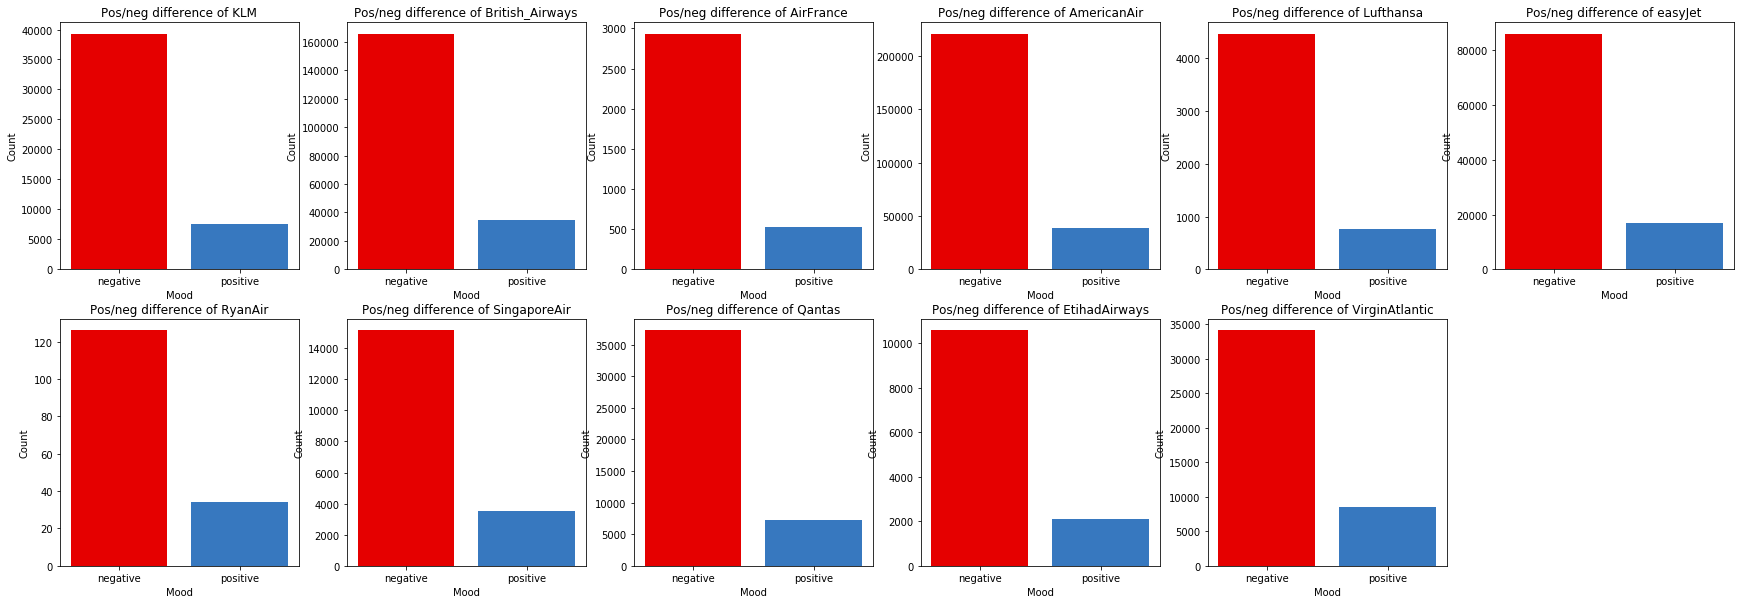

In [21]:
#there was nothing for airberlinassist so i just removed it to make the visualization better
air_names2 = ['KLM', 'British_Airways', 'AirFrance', 'AmericanAir', 'Lufthansa',  'easyJet', 'RyanAir', 'SingaporeAir', 'Qantas', 'EtihadAirways', 'VirginAtlantic'] 

plt.figure(1,figsize=(30, 10))

for i in air_names2:
    indices= air_names2.index(i)
    plt.subplot(2, 6, indices+1)
    new_df=jdf[jdf['airline']==i]
    count=new_df['class'].value_counts()
    Index = [1,2]
    colorsi = ["red", "windows blue"]
    plt.bar(Index, count, color=sns.xkcd_palette(colorsi))
    plt.xticks(Index,['negative','positive'])
    plt.ylabel('Count')
    plt.xlabel('Mood')
    plt.title('Pos/neg difference of '+i)

Percentage of positive and negative tweets sent to each airline.

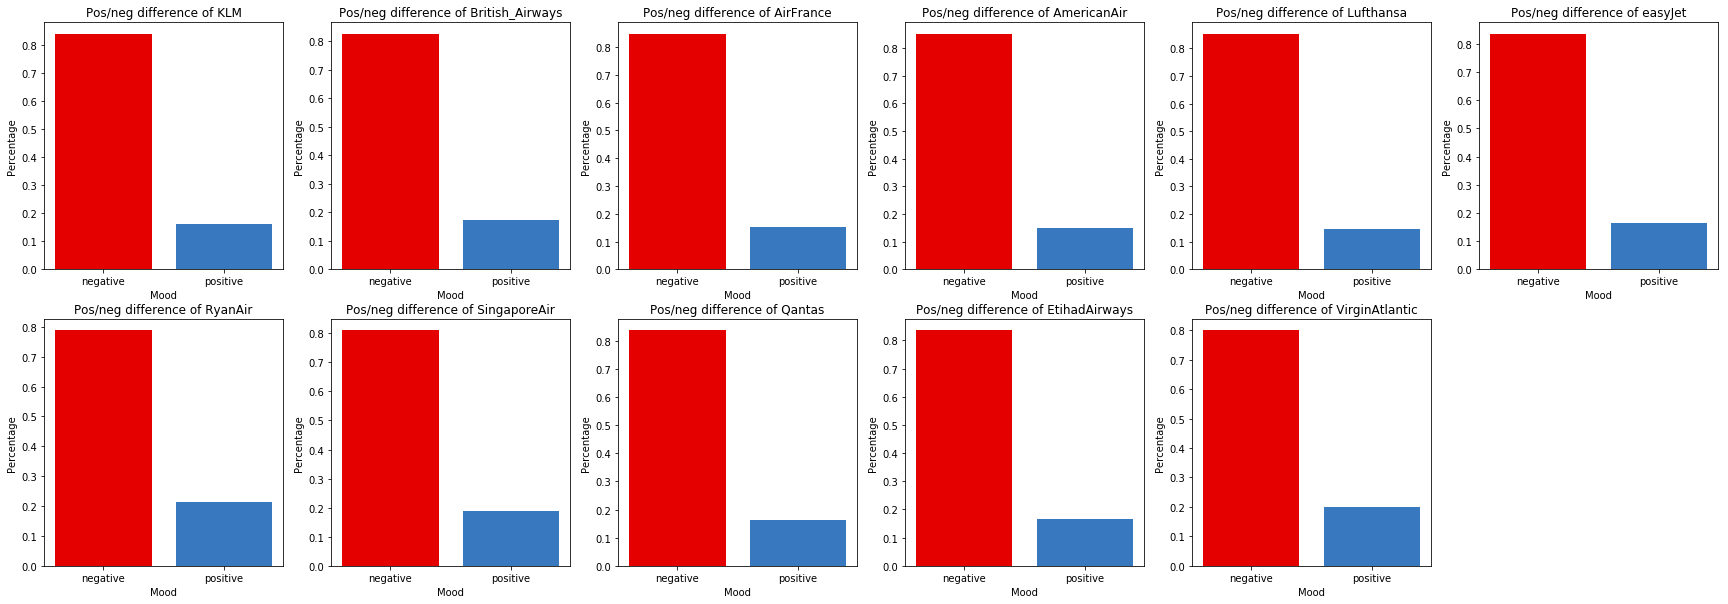

In [22]:
plt.figure(1,figsize=(30, 10))

for i in air_names2:
    indices= air_names2.index(i)
    plt.subplot(2, 6, indices+1)
    new_df=jdf[jdf['airline']==i]
    count=new_df['class'].value_counts()/len(new_df['tweet'])
    Index = [1,2]
    colorsi = ["red", "windows blue"]
    plt.bar(Index, count, color=sns.xkcd_palette(colorsi))
    plt.xticks(Index,['negative','positive'])
    plt.ylabel('Percentage')
    plt.xlabel('Mood')
    plt.title('Pos/neg difference of '+i)

Another clearer visualization for the differences between airlines. 

In [83]:
#.sort_values(by=jdf['airline'].value_counts())
#pd.crosstab(jdf['airline'], jdf['class']).sort_values('neg', ascending=False)
pd.crosstab(jdf['class'], jdf['airline']).apply(lambda x: x / x.sum() * 100, axis=0)#.plot(kind='bar',figsize=(8,8),stacked=True,color=sns.xkcd_palette(colorsi))

airline,AirFrance,AmericanAir,British_Airways,EtihadAirways,KLM,Lufthansa,Qantas,RyanAir,SingaporeAir,VirginAtlantic,easyJet
class,,,,,,,,,,,
neg,84.755568,85.14083,82.585018,83.539907,83.916891,85.258126,83.667371,78.75,80.977854,79.908216,83.45972
pos,15.244432,14.85917,17.414982,16.460093,16.083109,14.741874,16.332629,21.25,19.022146,20.091784,16.54028


In [1]:
v = pd.crosstab(jdf['airline'], jdf['class']).sort_values('neg', ascending=False)#.plot(kind="bar",title='Pos/Neg Received Tweets per Airline',figsize=(8,8),stacked=True, color=sns.xkcd_palette(colorsi))
v1 = v.plot(kind="bar",figsize=(8,8),stacked=True, color=sns.xkcd_palette(colorsi))
v1.get_xticklabels()[3].set_color('red')
v1.set_title('Pos/Neg Received Tweets per Airline', size=18, fontweight='bold')
v1.set_xlabel('Airline',fontweight='bold')
v1.set_ylabel('Count of tweets',fontweight='bold')
plt.xticks(rotation=45) 
plt.legend(bbox_to_anchor=(1.05, 1), loc=2);

NameError: name 'pd' is not defined

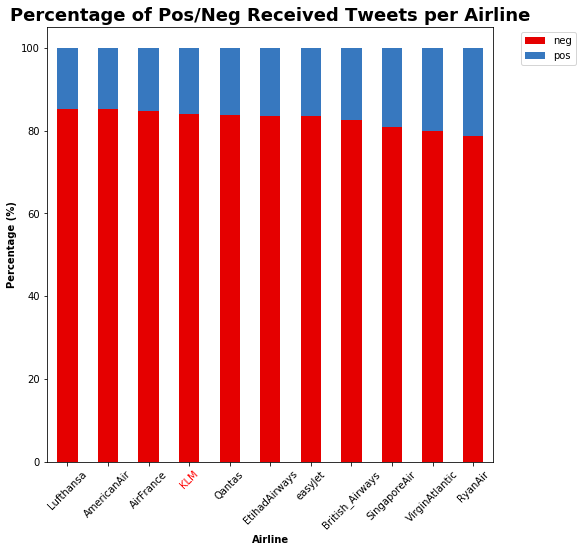

In [89]:
v1 = pd.crosstab(jdf['airline'], jdf['class']).apply(lambda x: x / x.sum() * 100, axis=1).sort_values('neg', ascending=False)
v2 = v1.plot(kind='bar',figsize=(8,8),stacked=True,color=sns.xkcd_palette(colorsi))
v2.get_xticklabels()[3].set_color('red')
v2.set_title('Percentage of Pos/Neg Received Tweets per Airline', size=18, fontweight='bold')
v2.set_xlabel('Airline', fontweight='bold')
plt.xticks(rotation=45) 
v2.set_ylabel('Percentage (%)' , fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2);

In [ ]:
with open('conversations.json', 'r') as convo_json:
    convos = json.load(convo_json)

### Getting the breastfeeding tweet replies sentiment

In [13]:
[t['id'] for t in tweets.find({}) if '@HeatherYemm Breastfeeding is permitted at KLM flights. However, to ensure that all our passengers of all backgrounds feel comfortable on board, we may request a mother to cover herself while breastfeeding, should other passengers be offended by this' in t['text'] if t['language']=='eng']


[1151049902673322000]

In [16]:
breast = pd.DataFrame()
breast['tweet'] = [t['text'] for t in tweets.find({}) if t['in_reply_to_status_id'] == 1151049902673322000 if t['language']=='eng']

In [20]:
breast.head(10)

,tweet
0,@KLM @HeatherYemm I don't even know what to say ☹️ permitted to feed a hungry child?? What if your attitude makes me uncomfortable? What would you put a blanket over then?
1,@KLM @HeatherYemm This is so wrong and upsetting. I have breastfed both my girls on many flights and I cannot imagine being asked to cover up because it offends someone to see a baby being fed. I guess I won’t be taking @klm. Unbelievably disappointing.
2,@KLM @HeatherYemm “Permitted” is the key problem here. \n\nIt should be “supported.” \n\nIf someone is “offended” they can look elsewhere or sit somewhere else.
3,"@KLM @HeatherYemm You seriously thought putting this policy out in the public domain was a good idea? Man, you gotta pay your marketing peeps more than minimum wage; this was a childish mistake. Gooooooood luck finding a new job, you novice Twitter manager. Bummer."
4,"@KLM @HeatherYemm no one “permits” anyone to breastfed, I’d maybe change your wording. If someone is offended they can firstly look away and then they look into the depths of their soul for the perverse reason they are offended by a woman feeding their child! Terrible policy!"
5,@KLM @HeatherYemm perhaps you hand that blanket to the person who would be offended and ask them cover their eyes instead of handing it to the mom
6,"@KLM @HeatherYemm Wow! Feeding an infant is ""pemitted"" on your flights?\n\n To ensure comfort of all passengers, please request those who are offended by feeding an infant to move, avert their eyes, or give them a blanket to cover their heads!"
7,@KLM @HeatherYemm Maybe covers should be handed out to passengers when they purchase something from the drinks trolley too. I find it offensive when people eat with their mouths open.
8,"@KLM @HeatherYemm Then I urge you to toss a blanket at everyone that flies with you. I can't stand people chewing with their mouths open, something which I see frequently. While breastfeeding is a necessity, open-mouth chewing is just bad manners."
9,"@KLM @HeatherYemm Wow. My partner fed our boy countless times on @easyJet on takeoff, landing and whenever he wanted it. No covering, no fuss, no issue. Pull your head from your arse, @KLM. If somebody is offended by breastfeeding then the issue is theirs, not the mothers. Support the mum first."


In [29]:
breast['tweet']=breast['tweet'].apply(cleantxt)

In [30]:
from collections import Counter
cnt = Counter()
for text in breast["tweet"].values:
    for word in text.split():
        cnt[word] += 1
        
#cnt.most_common(20)

[('to', 2618),
 ('a', 2283),
 ('the', 2061),
 ('you', 1515),
 ('is', 1377),
 ('and', 1322),
 ('i', 1043),
 ('of', 981),
 ('offended', 828),
 ('this', 807),
 ('be', 762),
 ('in', 718),
 ('that', 715),
 ('are', 711),
 ('if', 695),
 ('with', 693),
 ('breastfeeding', 686),
 ('not', 665),
 ('their', 664),
 ('cover', 656)]

In [31]:
FREQWORDS = set([w for (w, wc) in cnt.most_common(16)])
def remove_freqwords(text):
    """custom function to remove the frequent words"""
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

breast['tweet'] = breast['tweet'].apply(remove_freqwords)
#breast[['tweet']].head()

In [34]:
breast['class'] = breast['tweet'].apply(classify)

In [35]:
breast

,tweet,class
0,dont even know what say ☹️ permitted feed hungry child what your attitude makes me uncomfortable what would put blanket over then,neg
1,so wrong upsetting have breastfed both my girls on many s cannot imagine being asked cover up because it offends someone see baby being fed guess won’t taking unbelievably disappointing,neg
2,“permitted” key problem here it should “supported” someone “offended” they can look elsewhere or sit somewhere else,pos
3,seriously thought putting policy out public domain was good idea man gotta pay your marketing peeps more than minimum wage was childish mistake gooooooood luck finding new job novice twitter manager bummer,neg
4,no one “permits” anyone breastfed i’d maybe change your wording someone they can firstly look away then they look into depths their soul for perverse reason they by woman feeding their child terrible policy,neg
...,...,...
2093,im someone by baby feeding itself maybe it’s idea give person,neg
2094,nourishing baby loving supportive mutually beneficial act for baby lactating mother united states women legally protected breastfeed without cover immune any notion public indecency who trying stop baby from eating,neg
2095,mother feeding her child only offensive who have indecent thoughts when seeing it there nothing insulting offensive or disrespectful doing what women have done since beginning time tell other passengers mind their own business silly,neg
2096,quite stupid publish todays society only considering their own opinion as common rule get these stupid answers for some religions klm destinations its not acceptable for others more liberal it we better avoid selfish egocentric idiots onboard,neg


In [40]:
breast['class'].value_counts()/len(breast['tweet'])*100

neg    89.70448
pos    10.29552
Name: class, dtype: float64